## Expected Batting Average

### About

- This project aims to replicate the MLB statcast advanced stat "xBA"

### Goals

1) Use supervised ML to predict whether a batted ball is a hit ot an out based on:
    - Pitch velo
    - Exit velo
    - Launch angle
    - Hit location
    - Hit distance (in case HRs aren't given their own hit location?)
    - Batter speed (maybe)
    
2) Find the *expected* batting average for a batter given the above parameters for each batted ball in play 

3) Compare results with statcast's xBA results

### Data

- Data gathered from baseball savant (statcast) search
- Example search query to get all (?) batted balls resulting in outs in 2018 
    - https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=single%7Cdouble%7Ctriple%7Chome%5C.%5C.run%7Cfield%5C.%5C.out%7Cstrikeout%7Cstrikeout%5C.%5C.double%5C.%5C.play%7Cdouble%5C.%5C.play%7Cgrounded%5C.%5C.into%5C.%5C.double%5C.%5C.play%7Cfielders%5C.%5C.choice%7Cfielders%5C.%5C.choice%5C.%5C.out%7Cforce%5C.%5C.out%7Csac%5C.%5C.bunt%7Csac%5C.%5C.bunt%5C.%5C.double%5C.%5C.play%7Csac%5C.%5C.fly%7Csac%5C.%5C.fly%5C.%5C.double%5C.%5C.play%7Ctriple%5C.%5C.play%7C&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7C&hfC=&hfSea=2018%7C&hfSit=&player_type=batter&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfInfield=&team=&position=&hfOutfield=&hfRO=&home_road=&hfFlag=&hfPull=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_pas=0#results
    - seems like this returns a maximum of 40,000 results
- Data reference
    - https://baseballsavant.mlb.com/csv-docs

### Notes

- My plan is to use 2018 results in the training/test sets to determine 2019 xBA results
    - Need to think more about if this is the right strategy
- Is it possible to get spray chart info for this?
- Having hc_x and hc_y as two separate features doesn't really tell us much, we need the combination of the two as a vector:
    - $ hc = \sqrt{hc_y^2 + hc_x^2} \tan(y/x) $
    - ATTN: getting weird values here, need to plot to see if it makes sense

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from confusion import plot_confusion_matrix
%matplotlib inline

def spray_angle(df):
    '''
        Calculate spray angle from hc_x and hc_y in statcast csv output
    '''
    # make home plate (0,0)
    hc_x = df['hc_x'] - 125.42
    hc_y = 198.27 - df['hc_y']
    hc_x.fillna(0, inplace=True)
    hc_y.fillna(0, inplace=True)
    df['spray_angle'] = np.arctan(hc_x/hc_y)
    df.loc[df['stand'] == 'L', 'spray_angle'] = -df.loc[df['stand'] == 'L', 'spray_angle']
    # convert to degrees
    df['spray_angle'] = df['spray_angle'].apply(np.rad2deg)
    return(df)

def pre_process(df):
    '''
          Process dataframe for SVC, break df into features and results
    '''
    # define features
    features = [
            'launch_speed', 'launch_angle', 'spray_angle',
    ]
    # add outcome column
    df['hit'] = (df['events'].isin(['single', 'double', 'triple', 'home_run']))
    # process df
    df = spray_angle(df)
    df = df[['hit', *features]].dropna()
    # break into features (X) and outcomes (y)
    X, y = df[features], df['hit']
    # normalize to [0,1] scale
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X), columns=X.columns)
    return(X, y)

    
# data = pd.read_csv('hits_outs_2018.csv')
data = pd.read_csv('hits_outs_2017-18.csv')

X, y = pre_process(data)

X.describe()

# split up data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 13, test_size=0.2
)

clf = LinearSVC().fit(X_train, y_train)

print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print('\nCoefficients: ')
print(clf.coef_)

# calculate expected batting average for player
dee = pd.read_csv('dee_2019.csv')

X0, y0 = pre_process(dee)

predicted_outcomes = clf.predict(X0)
unique, counts = np.unique(predicted_outcomes, return_counts=True)
d = dict(zip(unique, counts))
xBA = d[True]/(d[False] + d[True])

hits = 0
for event in ['single', 'double', 'triple', 'home_run']:
    hits += dee['events'].value_counts()[event]

BA = hits/len(dee['events'])

print('\nPredicted batting average: {:.3f}'.format(xBA))
print('Actual batting average: {:.3f}'.format(BA))

Accuracy of Linear SVC classifier on training set: 0.69
Accuracy of Linear SVC classifier on test set: 0.71

Coefficients: 
[[ 2.02322559 -0.33135676 -0.05102835]]

Predicted batting average: 0.326
Actual batting average: 0.281


Normalized confusion matrix
[[0.78888889 0.21111111]
 [0.53333333 0.46666667]]


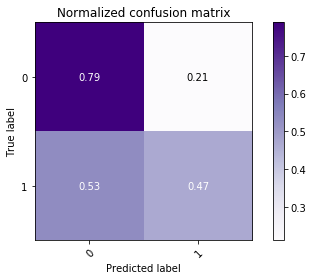

In [21]:
plot_confusion_matrix(y0, predicted_outcomes, [0, 1], normalize=True)
plt.show()

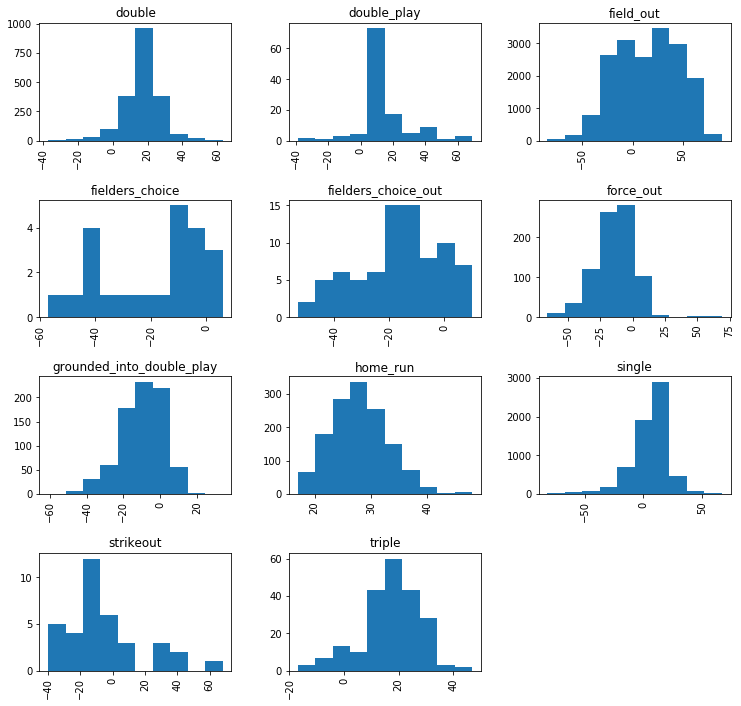

In [23]:
tmp = data[['events', 'launch_angle']].dropna()
tmp.hist(by='events', figsize=(12,12))
plt.show()

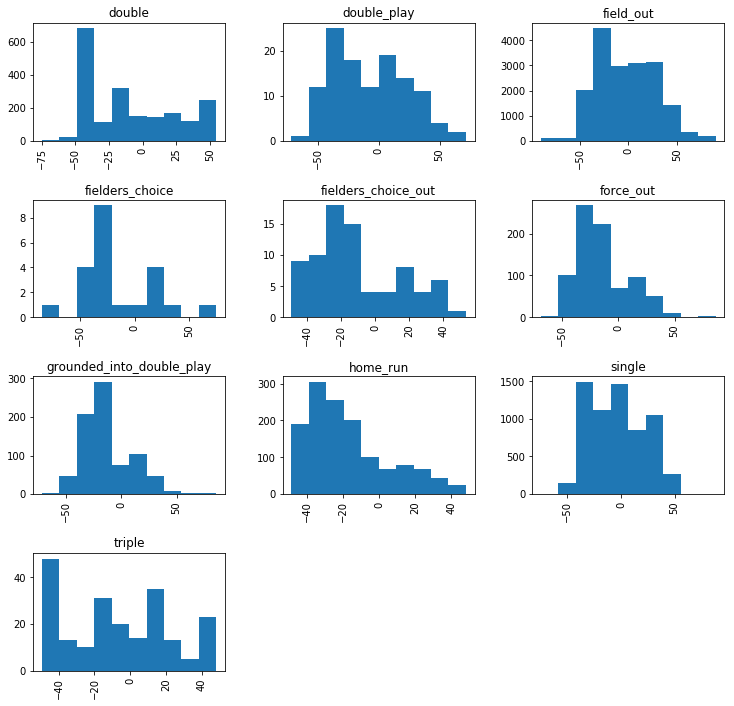

In [25]:
tmp = data[['events', 'spray_angle']].dropna()
tmp.hist(by='events', figsize=(12,12))
plt.show()

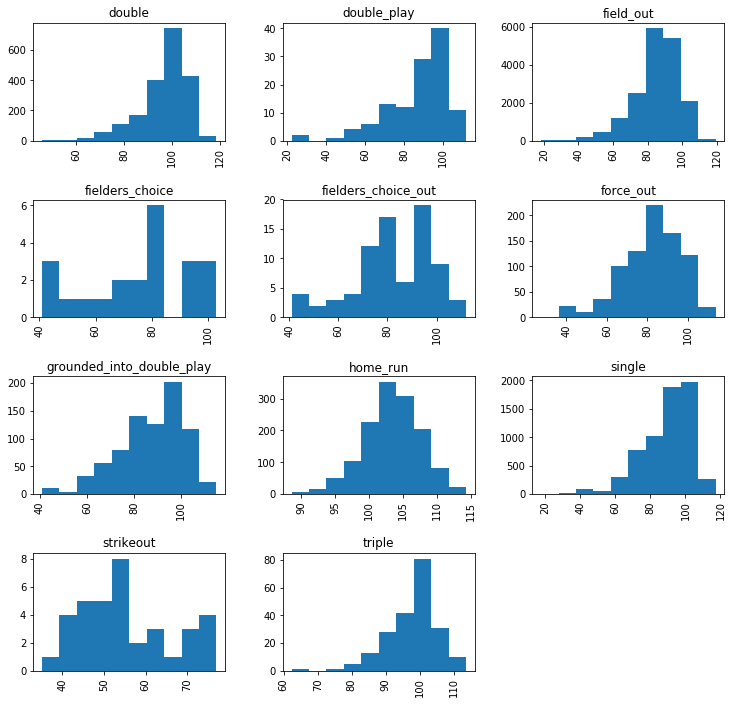

In [27]:
tmp = data[['events', 'launch_speed']].dropna()
tmp.hist(by='events', figsize=(12,12))
plt.show()

In [42]:
pd.describe_option('display')

display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]

display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]

display.column_space No description available.
    [default: 12] [currently: 12]

display.date_dayfirst : boolean
    When True, prints and parses dates with the day first, eg 20/01/2005
    [default: False] [currently: False]

display.date_yearfirst : boolean
    When True, prints and parses dates with the year first, eg 2005/01/20
    [default: False] [currently: False]

display.encoding : str/unicode
    Defaults to the detected encoding of the console.
    Specifies the encoding to be used for strings returned by to_string,
    these are generally strings meant to be displayed on the console.
    [default: UTF-8] 